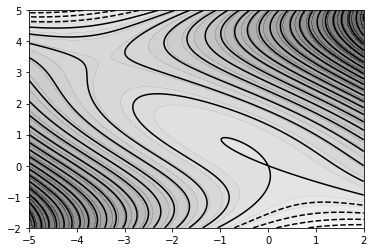

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#高度函數
def f(x,y):
    return  2*x**2+y**2+4*x*y+4/3*y**3-1/4*y**4

#建立網格
n = 1000
x = np.linspace(-5, 2, n)
y = np.linspace(-2, 5, n)
X,Y = np.meshgrid(x, y)

#繪製等高線圖
plt.contourf(X, Y, f(X, Y), 50, alpha=.6, cmap=plt.cm.binary)
C = plt.contour(X, Y, f(X, Y), 30, colors='black')

In [2]:
from math import sqrt
import numpy as np

# gradient
def nabla_f_x(x, y):
    return 4*x+4*y

def nabla_f_y(x, y):
    return 2*y + 4*x + 4*y**2 - y**3
    
def nabla_f(x, y):
    return np.array([nabla_f_x(x, y), nabla_f_y(x, y)])

# Hessian
def nabla_f_x_s(x, y):
    return 4

def nabla_f_x_y(x, y):
    return 4

def nabla_f_y_x(x, y):
    return 4

def nabla_f_y_s(x, y):
    return 2 + 8*y - 3*y**2

def Hessian(x, y):
    return np.array([[nabla_f_x_s(x, y), nabla_f_x_y(x, y)], [nabla_f_y_x(x, y), nabla_f_y_s(x, y)]])

In [3]:
# Consensus Optimization

gamma = 0.1

def L(x,y):
    return 1/2*np.linalg.norm(-nabla_f_x(x,y), nabla_f_y(x,y))^2

def v(x, y):
    return np.array([-nabla_f_x(x,y), nabla_f_y(x, y)])
    
def v_prime(x, y):
    return np.array([[-nabla_f_x_s(x, y), -nabla_f_x_y(x, y)], [nabla_f_y_x(x, y), nabla_f_y_s(x, y)]])

def nabla_L1(x,y):
    return -nabla_f_x_s(x, y)*(-nabla_f_x(x,y))+(nabla_f_y_x(x, y)*nabla_f_y(x, y))

def nabla_L2(x, y):
    return -nabla_f_x_y(x, y)*(-nabla_f_x(x,y))+nabla_f_y_s(x, y)*nabla_f_y(x, y)

def w(x, y, gamma):
    return v(x, y) - gamma*L(x,y)

def conopt(x, y, gamma, eta):
    x = x + eta*(-nabla_f_x(x, y)-
                 gamma*nabla_L1(x, y))
    y = y + eta*( nabla_f_y(x, y)-
                 gamma*nabla_L2(x, y))
    return x, y

In [4]:
# gradient descent
def gd(x, y, eta):
    x, y = x+eta*(-nabla_f_x(x, y)), y+eta*(nabla_f_y(x, y))
    return x, y
    
### cesp

#indicator function for lambda_x
def indicator_x(lambda_x):
    if lambda_x < 0:
        return 1
    else: 
        return 0

#indicator function for lambda_y
def indicator_y(lambda_y):
    if lambda_y > 0:
        return 1
    else: 
        return 0

# sign_function
def sign(x):
    if x >= 0:
        return 1
    else: 
        return -1
    
## Extreme Curvature Direction
def v_z_m(x, y, rho_x):
    if type(x) == np.ndarray:
        x= float(x[0])
        print('x')
    if type(y) == np.ndarray:
        y= float(y[0])
    #lambda_x, v_x, lambda_y, v_y = eigen(x, y)
    v = 1
    H = Hessian(x, y)
    l = H[0][0]
    #a = np.dot(v_x[0].T, nabla_f_x(x, y))
    #return indicator_x(lambda_x)*lambda_x/(2*rho_x)*sign(a)*v_x[0]
    a = np.dot(v, nabla_f_x(x, y))
    return indicator_x(l)*l/(2*rho_x)*sign(a)*v
        
def v_z_p(x, y, rho_y):
    if type(x) == np.ndarray:
        x = float(x[0])
    if type(y) == np.ndarray:
        y = float(y[0])
    #lambda_x, v_x, lambda_y, v_y = eigen(x, y)
    #b = np.dot(v_y[1].T, nabla_f_y(x, y))
    #return indicator_y(lambda_y)*lambda_y/(2*rho_y)*sign(b)*v_y[1]
    v=-1
    H=Hessian(x, y)
    l=H[1][1]
    b=np.dot(v, nabla_f_y(x,y))
    return indicator_y(l)*l/(2*rho_y)*sign(b)*v
    
def v_z(x, y, rho_x, rho_y):
    return np.array([v_z_m(x, y, rho_x), v_z_p(x, y, rho_y)])
    
def eigen(x, y):
    H_z = Hessian(x, y)
    l, v = np.linalg.eig(H_z)
    return l[0], v[0], l[1], v[1]
    
# update
def cesp(x, y, rho_x, rho_y,eta):
    lambda_x, v_x, lambda_y, v_y = eigen(x, y)
    #print('v_z_m:', v_z_m(x, y, rho_x))
    #print('v_z_p:', v_z_p(x, y, rho_y))
    x = x+v_z_m(x, y, rho_x)+eta*(-nabla_f_x(x, y))
    y = y+v_z_p(x, y, rho_y)+eta*nabla_f_y(x, y)
    return x, y

def cnco(x, y, rho_x, rho_y, gamma, eta):
    x = x+v_z_m(x, y, rho_x)+eta*(-nabla_f_x(x, y)-gamma*nabla_L1(x, y))
    y = y+v_z_p(x, y, rho_y)+eta*(nabla_f_y(x, y)-gamma*nabla_L2(x, y))
    return x, y

In [5]:
### setting parameter
# critical point
z0 = np.array([0, 0])
z1 = np.array([-2-sqrt(2), 2+sqrt(2)])
z2 = np.array([-2+sqrt(2), 2-sqrt(2)])

# initial point
init_point = [-3,-1]

# lipschitz constant
rho_x = 1e-4  # not sure
rho_y = 20   # not sure

# Hessian of each critical point
H_z0 = Hessian(z0[0], z0[1])
H_z1 = Hessian(z1[0], z1[1])
H_z2 = Hessian(z2[0], z2[1])

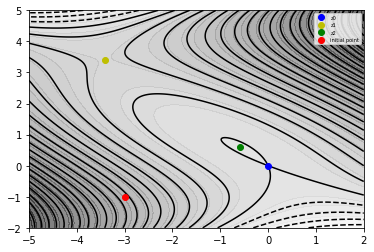

In [6]:
plt.contourf(X, Y, f(X, Y), 50, alpha=.6, cmap=plt.cm.binary)
C = plt.contour(X, Y, f(X, Y), 30, colors='black')
plt.plot(z0[0], z0[1], 'bo', label='point')
plt.plot(z1[0], z1[1], 'yo', label='point')
plt.plot(z2[0], z2[1], 'go', label='point')
plt.plot(init_point[0], init_point[1], 'ro', label='point')
plt.legend(['z0', 'z1', 'z2', 'initial point'], loc='upper right',fontsize=5)

In [7]:
gd_list = [init_point]

eta = 0.01
iteration = 10000
x, y = init_point
for i in range(iteration):
    x, y = gd(x, y, eta)
    gd_list.append([x, y])
    
    if nabla_f_x(x, y)<1e-5 and nabla_f_x(x, y)>-1e-5:
        print(i)
        break
    elif nabla_f_y(x, y)<1e-5 and nabla_f_y(x, y)>-1e-5:
        print(i)
        break

868


In [8]:
cesp_list = [init_point]
x, y = init_point
for i in range(iteration):
    x, y = cesp(x, y, rho_x, rho_y, eta)
    cesp_list.append([x, y])
    if nabla_f_x(x, y)<1e-5 and nabla_f_x(x, y)>-1e-5:
        print(i)
        break
    elif nabla_f_y(x, y)<1e-5 and nabla_f_y(x, y)>-1e-5:
        print(i)
        break

288


In [9]:

conopt_list = [init_point]
x, y = init_point
for i in range(iteration):
    x, y = conopt(x, y, gamma, eta)
    conopt_list.append([x, y])
    if nabla_f_x(x, y)<1e-5 and nabla_f_x(x, y)>-1e-5:
        print(i)
        break
    elif nabla_f_y(x, y)<1e-5 and nabla_f_y(x, y)>-1e-5:
        print(i)
        break

534


In [10]:
cnco_list = [init_point]
x, y = init_point
for i in range(iteration):
    x, y = cnco(x, y, rho_x, rho_y, gamma, eta)
    cnco_list.append([x, y])
    if nabla_f_x(x, y)<1e-5 and nabla_f_x(x, y)>-1e-5:
        print(i)
        break
    elif nabla_f_y(x, y)<1e-5 and nabla_f_y(x, y)>-1e-5:
        print(i)
        break

207


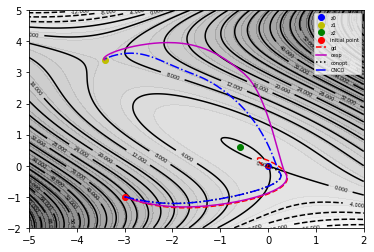

In [11]:
x_list = []
y_list = []
for i in range(len(gd_list)):
    x_list.append(gd_list[i][0])
    y_list.append(gd_list[i][1])
x_list_cesp = []
y_list_cesp = []
for i in range(len(cesp_list)):
    x_list_cesp.append(cesp_list[i][0])
    y_list_cesp.append(cesp_list[i][1])

x_list_conopt = []
y_list_conopt = []
for i in range(len(conopt_list)):
    x_list_conopt.append(conopt_list[i][0])
    y_list_conopt.append(conopt_list[i][1])

x_list_cnco = []
y_list_cnco = []
for i in range(len(cnco_list)):
    x_list_cnco.append(cnco_list[i][0])
    y_list_cnco.append(cnco_list[i][1])
    
plt.contourf(X, Y, f(X, Y), 50, alpha=.6, cmap=plt.cm.binary)
C = plt.contour(X, Y, f(X, Y), 30, colors='black')
plt.clabel(C,inline=True, fontsize=5)
plt.plot(z0[0], z0[1], 'bo', label='point')
plt.plot(z1[0], z1[1], 'yo', label='point')
plt.plot(z2[0], z2[1], 'go', label='point')
plt.plot(init_point[0], init_point[1], 'ro', label='point')
plt.plot(x_list, y_list, 'r--',markersize=1)
plt.plot(x_list_cesp, y_list_cesp, 'm-',markersize=1)
plt.plot(x_list_conopt, y_list_conopt, 'k:',markersize=1)
plt.plot(x_list_cnco, y_list_cnco, 'b-.', markersize=1)
plt.legend(['z0', 'z1', 'z2', 'initial point', 'gd', 'cesp', 'conopt', 'CNCO'], loc='upper right',fontsize=5)
plt.savefig('gd_vs_cesp.png',transparent=False, dpi=1800, pad_inches = 0)